In [201]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs
plt.rcParams.update({"font.size": 12})

class els_labels:
    def __init__(self, els, H, L):
        xmid = np.copy(els.x_centers)
        ymid = np.copy(els.y_centers)
        self.top = ymid == H  # top
        self.right = xmid == L  # right
        self.bot = ymid == -H  # top
        self.left = xmid == -L  # left
        self.interior = (xmid > -L) & (xmid < L) & (ymid > -H) & (ymid < H)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wavy fault in a box
Below we consider a toy problem based on laboratory rock deformation experiments. A sinusoidal fault is embedded inside a rectangular uniform elastic rectangular box. 

The boundary conditions for this problem are as follows:
- $u_x = 1, u_y = 0$ at the top
- $u_x = -1, u_y = 0$ at the bottom
- traction-free boundary conditions ($\tau_x,\tau_y = 0$) on the left & right boundaries 
- mixed: static friction ($\tau_s - f\tau_n= 0$) and no tensile slip ($s_n= 0$) at interior fault elements

In [202]:
# Elastic parameters
mu = 1
nu = 0.25
friction_coeff = 0.2

In [203]:
# Create a box mesh with a sinusoidal fault in the middle
L = 4.0
H = 4.0
ngrid = 4
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt(
        (corners[i, 0] - corners[(i + 1), 0]) ** 2
        + (corners[i, 1] - corners[(i + 1), 1]) ** 2
    )
    xi = np.linspace(
        corners[i][0],
        corners[(i + 1) % 4][0],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    zi = np.linspace(
        corners[i][1],
        corners[(i + 1) % 4][1],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    x.append(xi)
    z.append(zi)
x.append(corners[0, 0])
z.append(corners[0, 1])
x = np.hstack(x)
z = np.hstack(z)

x1_box = x[0:-1]
x2_box = x[1:]
y1_box = z[0:-1]
y2_box = z[1:]

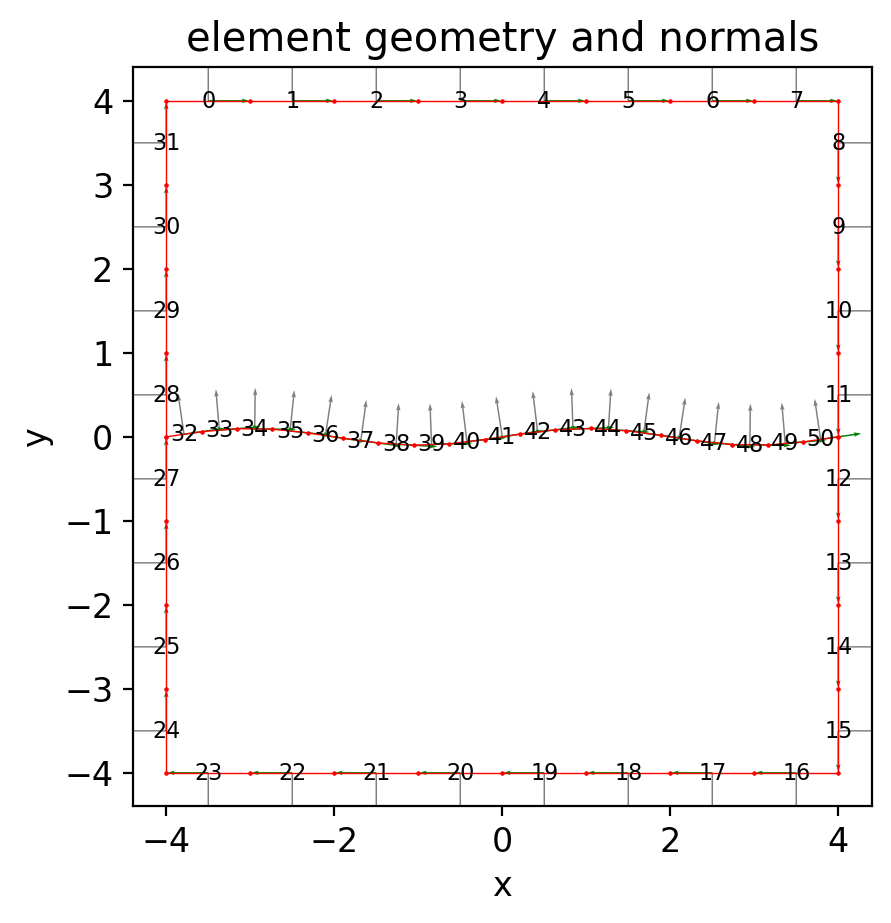

In [204]:
# Across the middle: Create a sinusoidal fault centered around y=0
ngridf = 10

x = np.linspace(-1.0 * L, 1.0 * L, int(2 * ngridf))
z = 0.1 * np.sin(2 * np.pi * x / 2 / 2)
# Force the first and last z-values to be 0
z[0] = 0
z[-1] = 0
x1_across = x[0:-1]
x2_across = x[1:]
y1_across = z[0:-1]
y2_across = z[1:]

els = bemcs.initialize_els()
els.x1 = np.concatenate([x1_box, x1_across])
els.y1 = np.concatenate([y1_box, y1_across])
els.x2 = np.concatenate([x2_box, x2_across])
els.y2 = np.concatenate([y2_box, y2_across])

bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# add labels for top,right,bot,left,interior
labels = els_labels(els, H, L)

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [205]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)

N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Number of open nodes = 0
: []
Number of 2-overlap nodes = 48
: [array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([  0, -95]), array([ 99, -98]), array([ 102, -101]), array([ 69, -68]), array([ 3, -2]), array([ 105, -104]), array([ 108, -107]), array([ 66, -65]), array([ 6, -5]), array([ 111, -110]), array([ 114, -113]), array([ 117, -116]), array([ 63, -62]), array([ 9, -8]), array([ 120, -119]), array([ 123, -122]), array([ 60, -59]), array([ 12, -11]), array([ 126, -125]), array([ 129, -128]), array([ 57, -56]), array([ 15, -14]), array([ 132, -131]), array([ 135, -134]), array([ 138, -137]), array([ 54, -53]), array([ 18, -17]), array([ 141, -140]), array([ 144, -143]), array([ 51, -50]), array([ 21, -20]), array([ 147, -146]), array([ 150, -149]), array([ 48, -47]), array([ 45, -44]), array([ 42, -41]), array([ 39, -38]), array([ 33, -32]), array([ 30, -29]), array([ 27, -26]), array([ 24, -23

# Boundary Conditions
Here we implement the various boundary conditions as a big vector that goes in the right hand side of the Integral equations. The convention we follow is:
- BCs at node centers
- BCs at open nodes
- BCs at interior 2-overlap nodes
- BCs at triple junctions (this is experimental currently)

In [206]:
# Nequations = N_c + N_o + N_i + N_t
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# Boundary conditions are
# top: ux = 1, uy = 0
# right: traction-free
# bot: ux = -1, uy = 0
# left: traction-free
# interior: static friction, no normal slip
bc_x = np.zeros((n_els, 1))
bc_y = np.zeros((n_els, 1))

bc_x[labels.top] = 1.0
bc_y[labels.top] = -0.0
bc_x[labels.bot] = -1.0
bc_y[labels.bot] = -0.0

bc_x[labels.right] = -0.0
bc_y[labels.right] = 0.0
bc_x[labels.left] = 0.0
bc_y[labels.left] = 0.0

# traction BCs at interior fault centers
# set t_s - f*t_n = 0, or t_s - f*t_n = residual_traction
# s_n = 0
bc_x[labels.interior] = 0.0  # residual or pre-stress level
# bc_x[labels.interior] = np.random.normal(
#     loc=0, scale=0.1, size=(len(x1_across), 1)
# )  # random residual stress field
bc_y[labels.interior] = 0.0

BC_c[0::2] = bc_x
BC_c[1::2] = bc_y
# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# Design Matrix System 
Here we implement various boundary conditions at the different types of nodes we have
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we are currently implementing 2 equations for conservation of slip and 4 equations for smoothness (these choices are likely to change in the future)

In [207]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)

# Patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
obs_xy = (
    np.vstack((els.x_centers, els.y_centers)).T
    - np.vstack((els.x_normals, els.y_normals)).T * 1e-8
)
x_obs = obs_xy[:, 0].reshape(-1, 1)
y_obs = obs_xy[:, 1].reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="local")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="local")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

for i in range(5):
    if i == 0:
        idx = labels.top.flatten()
        kernel_for_x_s = kernels_s[3]
        kernel_for_x_n = kernels_n[3]
        kernel_for_y_s = kernels_s[4]
        kernel_for_y_n = kernels_n[4]
    elif i == 1:
        idx = labels.bot.flatten()
        kernel_for_x_s = kernels_s[3]
        kernel_for_x_n = kernels_n[3]
        kernel_for_y_s = kernels_s[4]
        kernel_for_y_n = kernels_n[4]
    elif i == 2:
        idx = labels.left.flatten()
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]
    elif i == 3:
        idx = labels.right.flatten()
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]
    else:
        idx = labels.interior.flatten()
        kernel_for_x_s = traction_kernels_s[0] - friction_coeff * traction_kernels_s[1]
        kernel_for_x_n = traction_kernels_n[0] - friction_coeff * traction_kernels_n[1]
        # kernel_for_y_s = traction_kernels_s[1]
        # kernel_for_y_n = traction_kernels_n[1]

    # x-kernels
    kerneleval_x[idx, 0::6] = kernel_for_x_s[idx, 0::3]
    kerneleval_x[idx, 1::6] = kernel_for_x_s[idx, 1::3]
    kerneleval_x[idx, 2::6] = kernel_for_x_s[idx, 2::3]
    kerneleval_x[idx, 3::6] = kernel_for_x_n[idx, 0::3]
    kerneleval_x[idx, 4::6] = kernel_for_x_n[idx, 1::3]
    kerneleval_x[idx, 5::6] = kernel_for_x_n[idx, 2::3]

    # y-kernels
    if i != 4:
        kerneleval_y[idx, 0::6] = kernel_for_y_s[idx, 0::3]
        kerneleval_y[idx, 1::6] = kernel_for_y_s[idx, 1::3]
        kerneleval_y[idx, 2::6] = kernel_for_y_s[idx, 2::3]
        kerneleval_y[idx, 3::6] = kernel_for_y_n[idx, 0::3]
        kerneleval_y[idx, 4::6] = kernel_for_y_n[idx, 1::3]
        kerneleval_y[idx, 5::6] = kernel_for_y_n[idx, 2::3]
    else:
        kerneleval_y[idx, :] = matrix_slip[3::6, :][idx, :]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

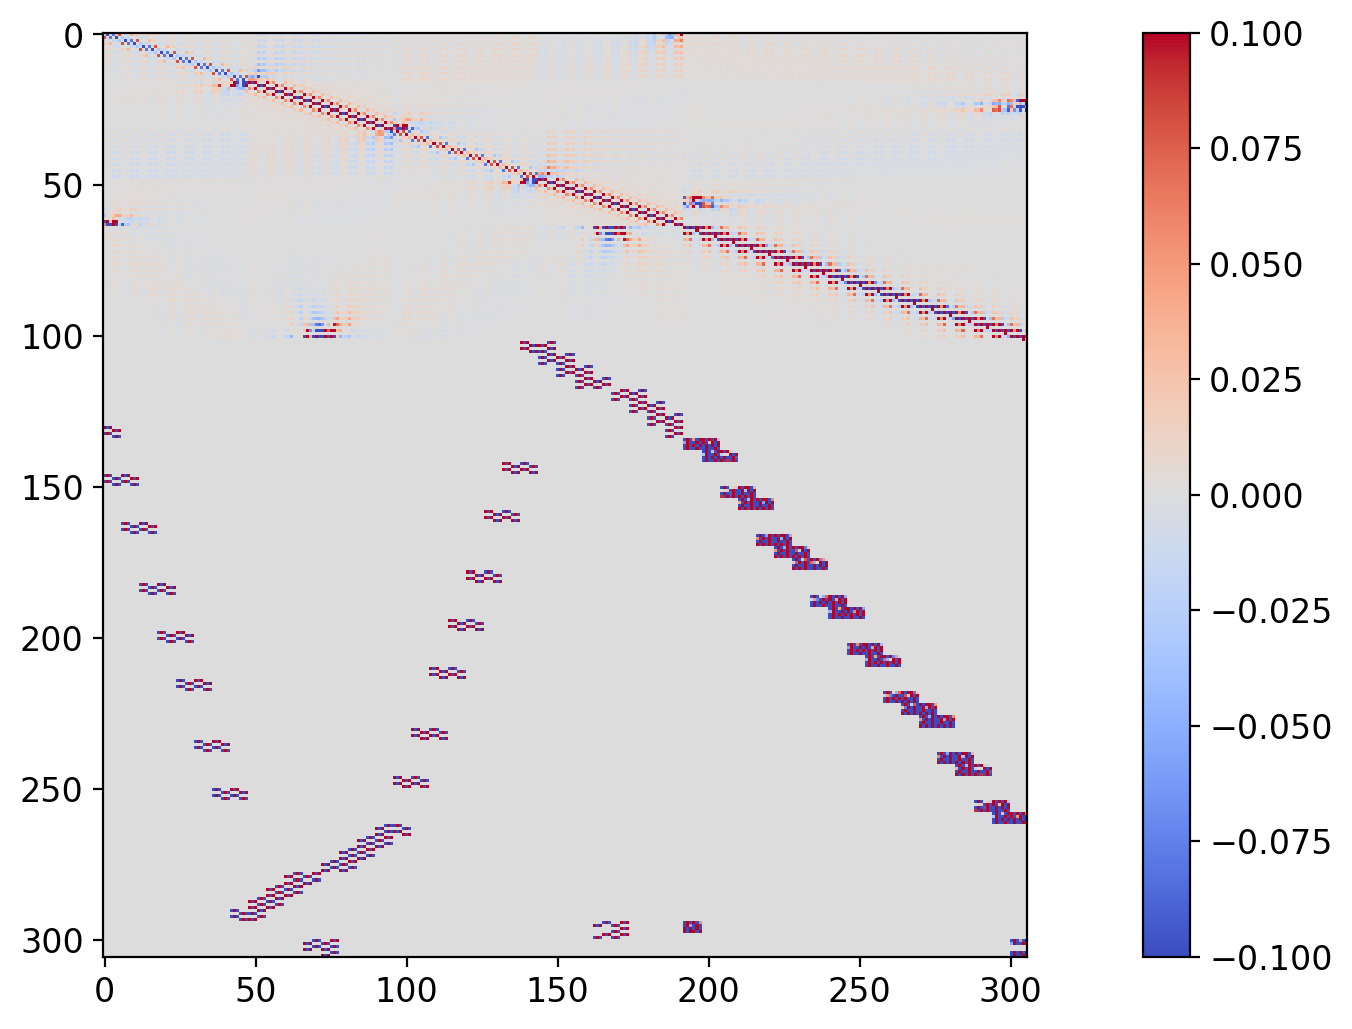

In [208]:
matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(15, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-0.1, 0.1)
plt.show()

# Solve system

In [209]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

# compute stress components exactly on the fault centers
sxy_f = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n
syy_f = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n

Linear Operator Condition Number: 1463.815758453255


# Plot displacement and stress components in the medium

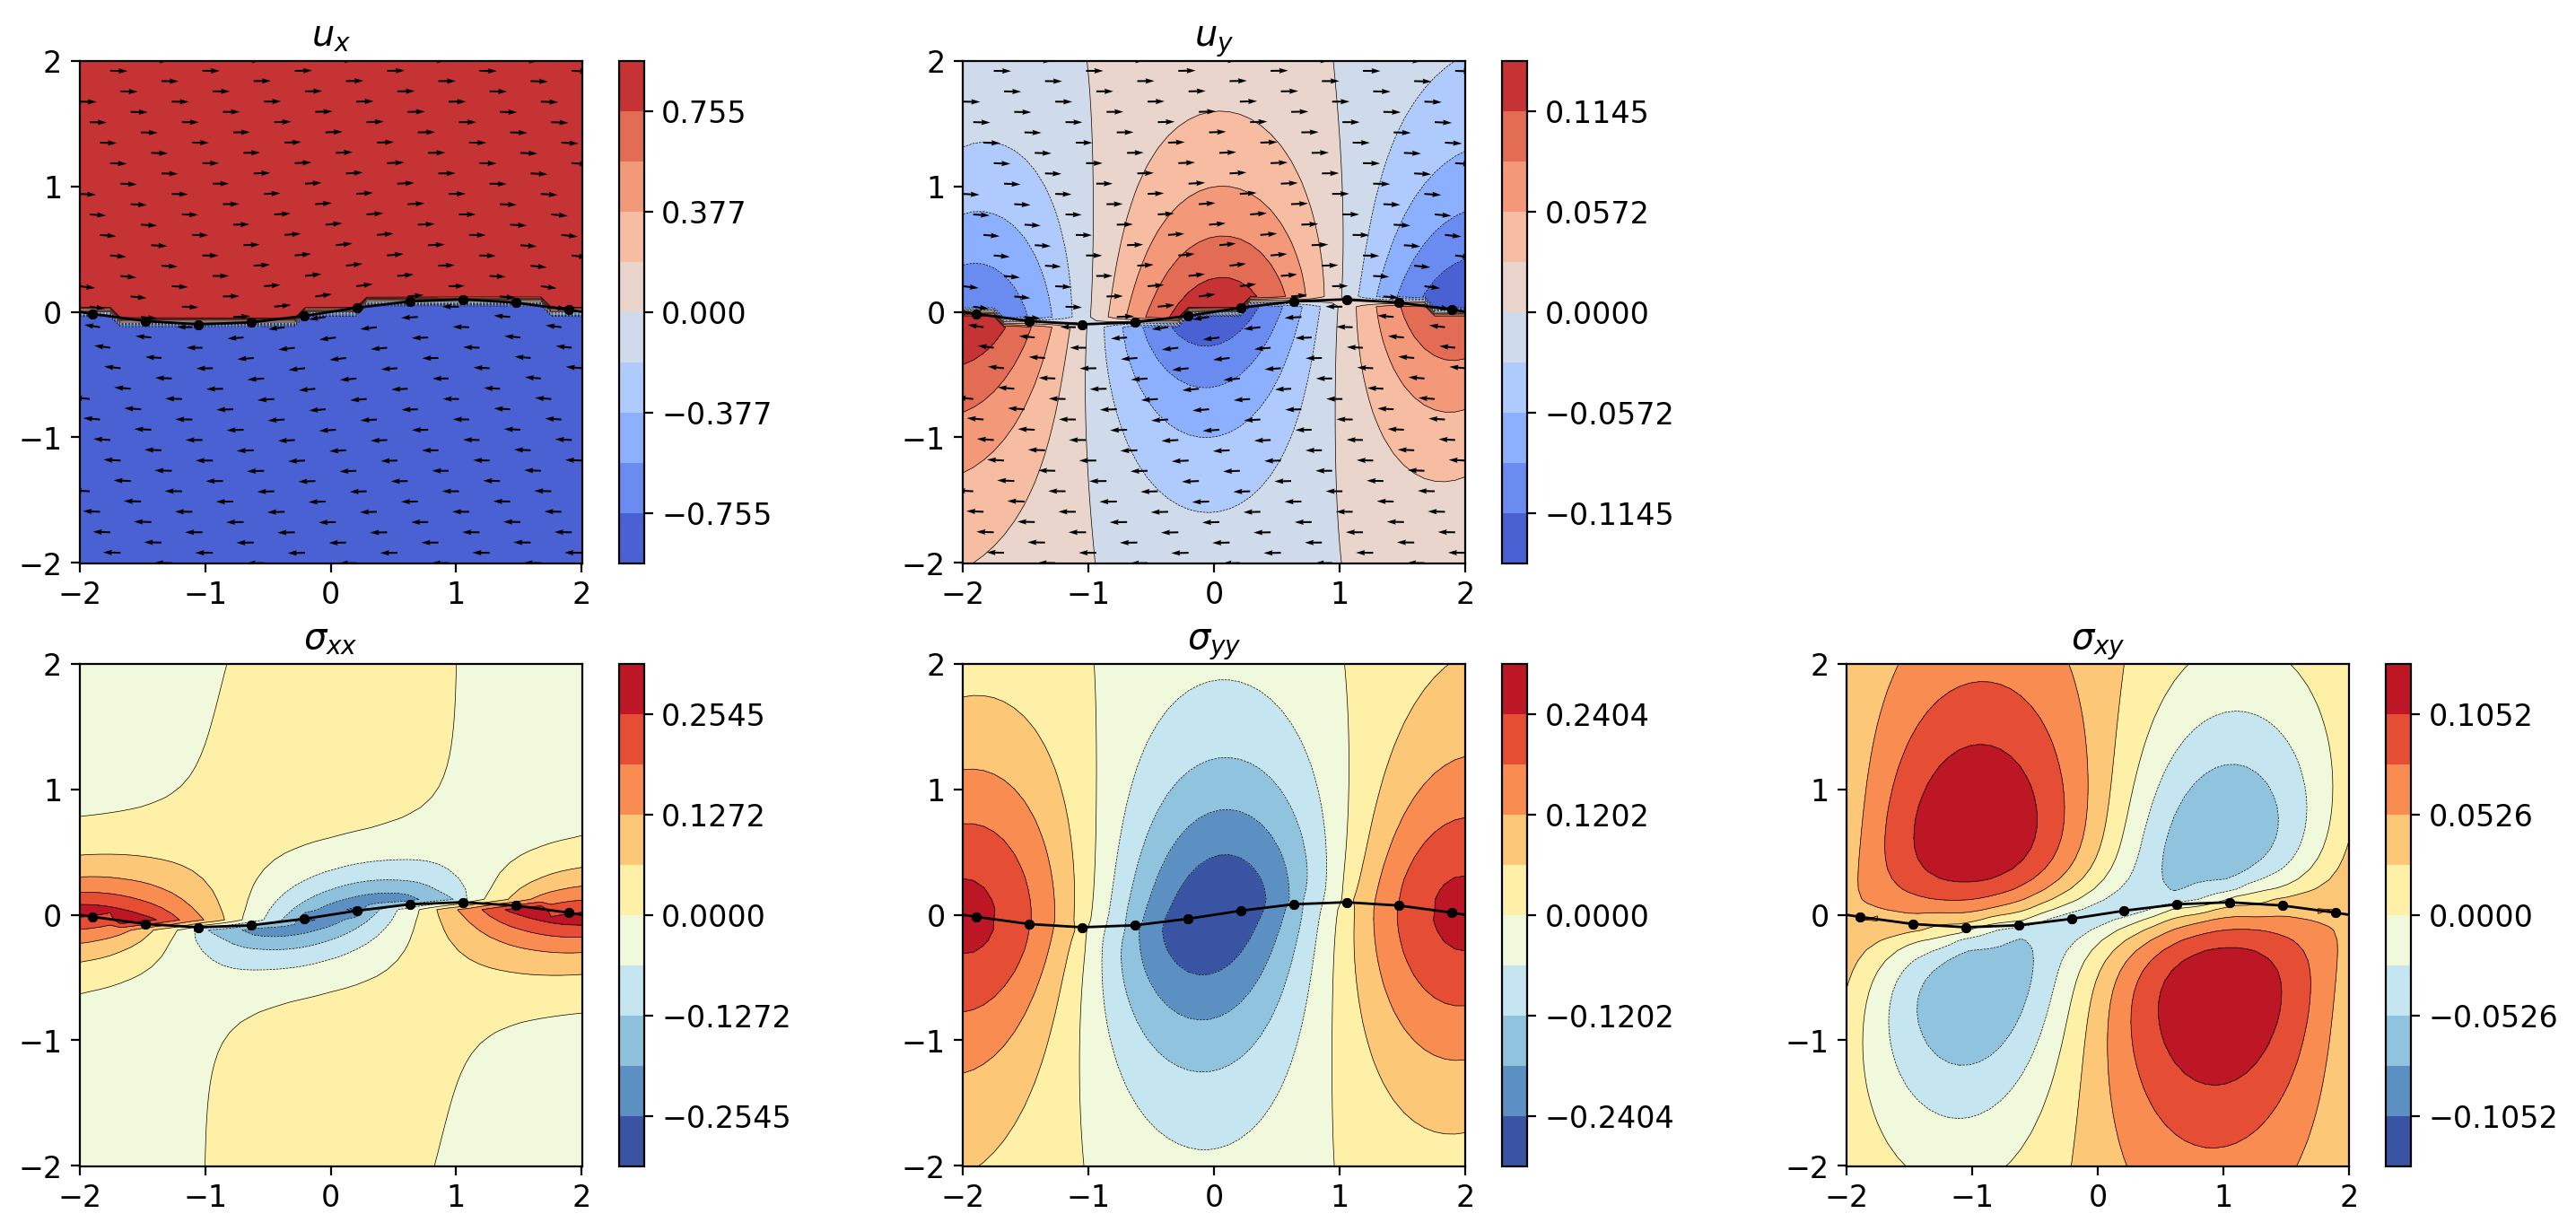

In [210]:
# Observation points
n_obs = 50
width = 2.001
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width, width, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=9
)

## Plot slip on the wavy fault

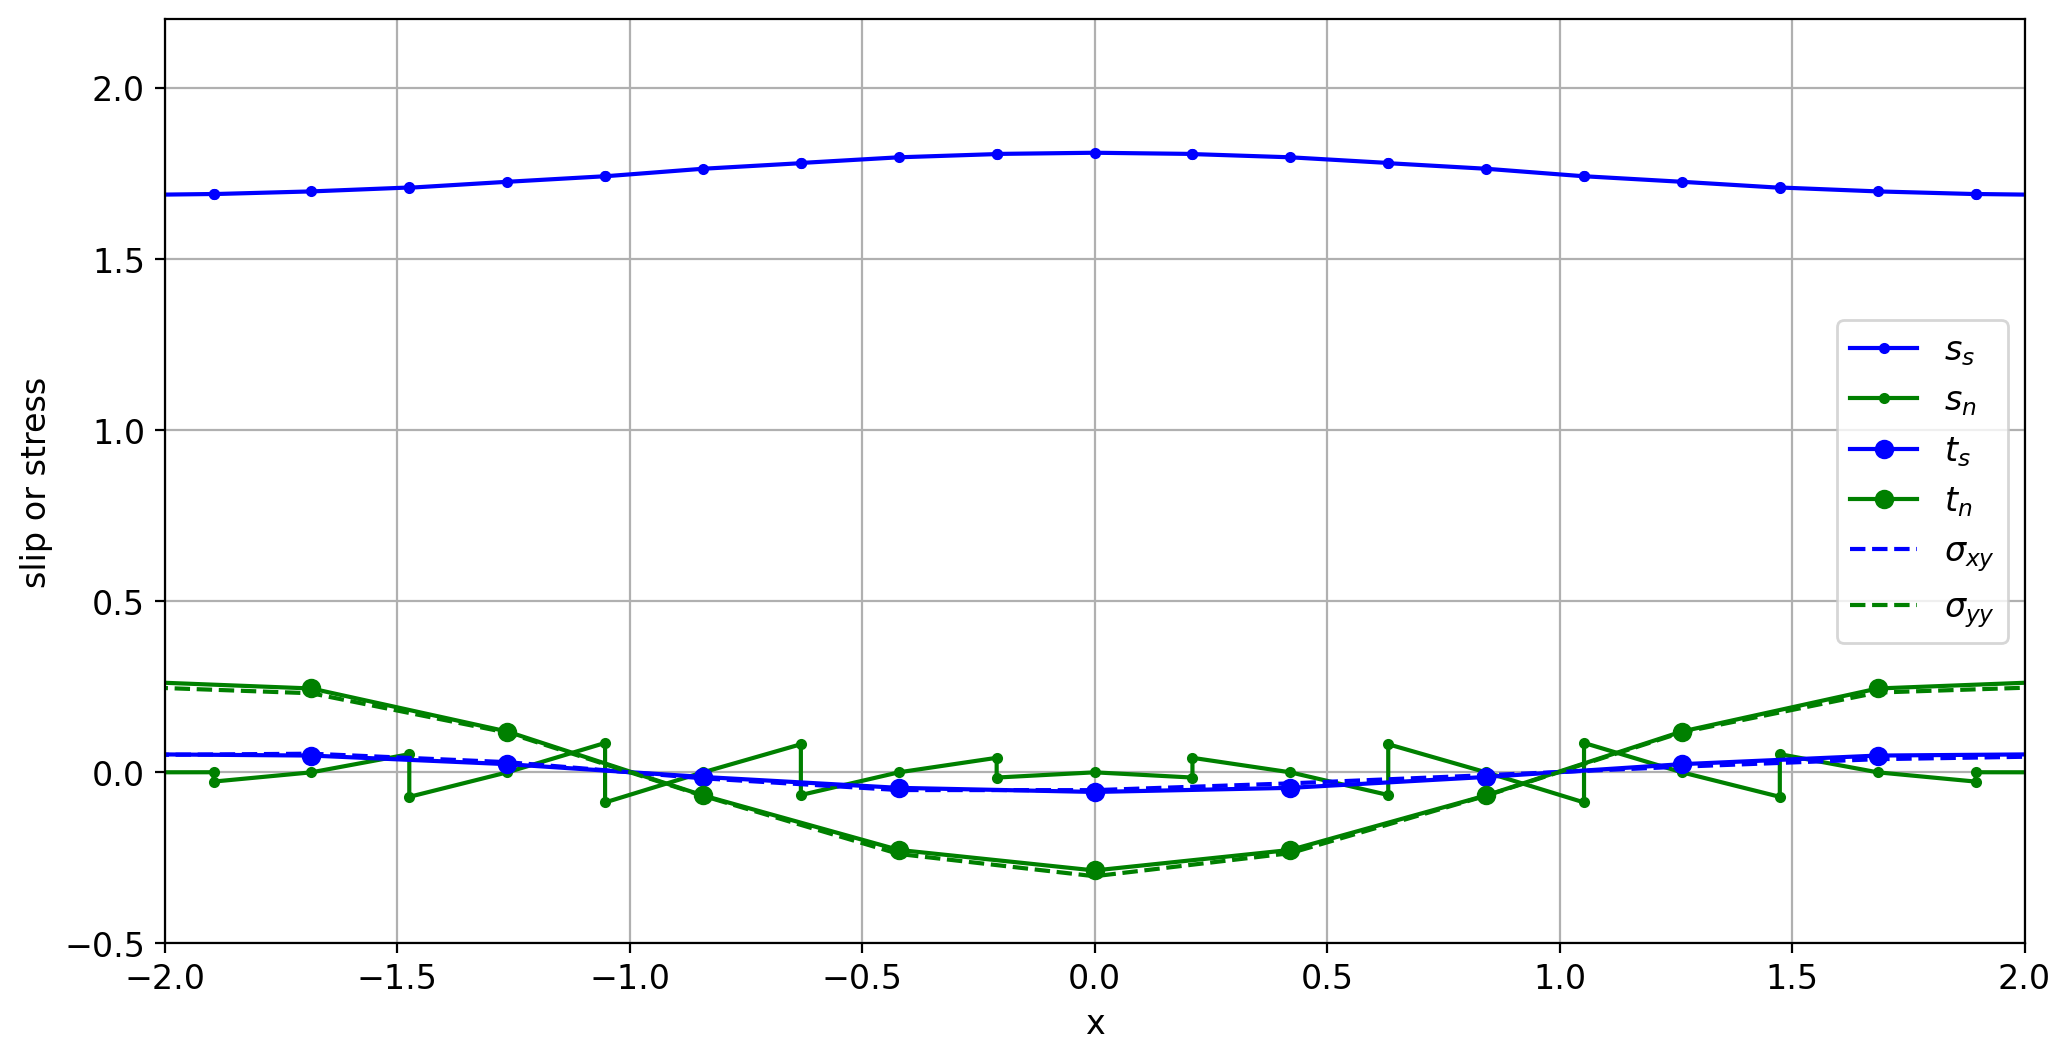

In [211]:
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)
# Extract slip at nodes from quadratic coefficients in the required coordinate system (global - x,y or local - s,n)
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))

# compute traction components
ts = (
    traction_kernels_s[0] @ quadratic_coefs_s
    + traction_kernels_n[0] @ quadratic_coefs_n
)
tn = (
    traction_kernels_s[1] @ quadratic_coefs_s
    + traction_kernels_n[1] @ quadratic_coefs_n
)
# ts = kerneleval_x @ quadratic_coefs
# tn = kerneleval_y @ quadratic_coefs

plt.figure(figsize=(12, 6))
xplot = np.zeros([len(els.x_centers[labels.interior]) * 3, 1])
s_s = np.zeros_like(xplot)
s_n = np.zeros_like(xplot)

xplot[0::3, 0] = els.x1[labels.interior]
xplot[1::3, 0] = els.x_centers[labels.interior]
xplot[2::3, 0] = els.x2[labels.interior]
for i in range(0, 3):
    s_s[i::3] = slip_nodes_x[i::3][labels.interior]
    s_n[i::3] = slip_nodes_y[i::3][labels.interior]

plt.plot(xplot, s_s, "b.-", label="$s_s$")
plt.plot(xplot, s_n, "g.-", label="$s_n$")
plt.plot(els.x_centers[labels.interior], ts[labels.interior], "bo-", label="$t_s$")
plt.plot(els.x_centers[labels.interior], tn[labels.interior], "go-", label="$t_n$")
plt.plot(
    els.x_centers[labels.interior], sxy_f[labels.interior], "b--", label="$\sigma_{xy}$"
)
plt.plot(
    els.x_centers[labels.interior], syy_f[labels.interior], "g--", label="$\sigma_{yy}$"
)
plt.xlabel("x")
plt.ylabel("slip or stress")
plt.ylim([-0.5, 2.2])
plt.xlim([-2, 2])
plt.legend()
plt.grid()
plt.show()

## Plot shear stress in the medium

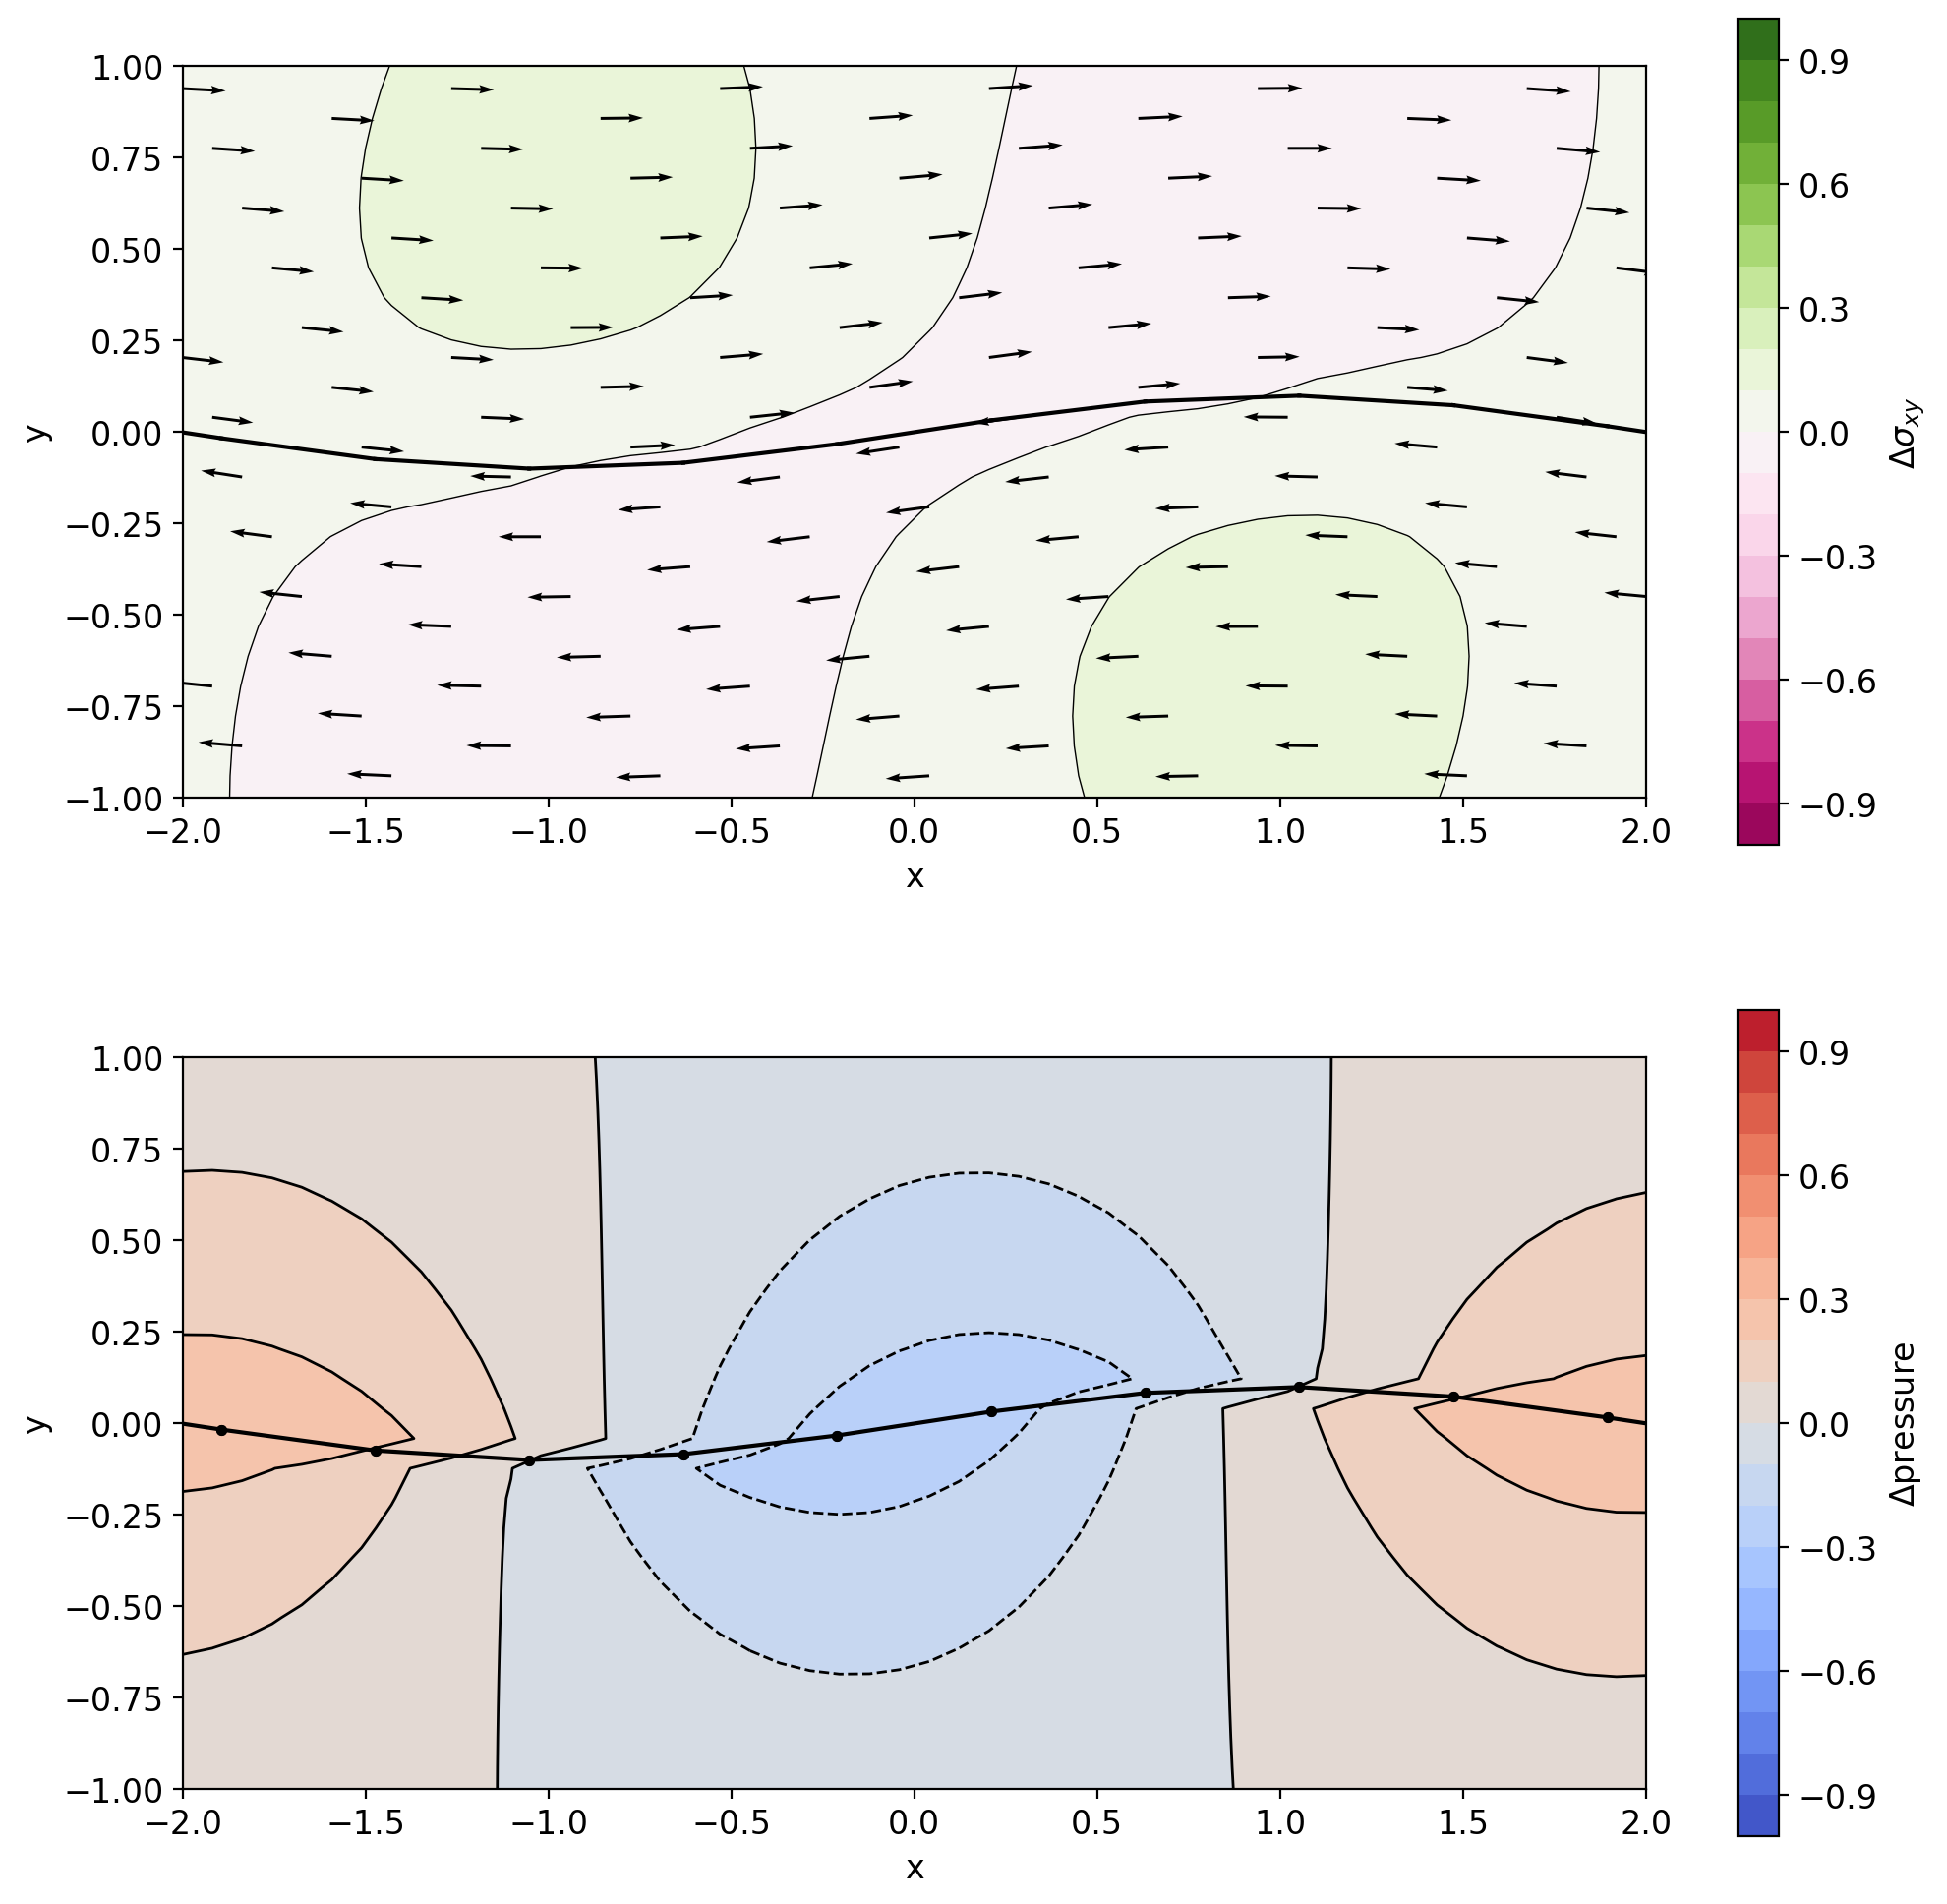

In [212]:
n_skip_plot = 9
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
toplot = sxy.reshape(n_obs, n_obs)
maxval = 1  # np.max(np.abs(toplot))
minval = -maxval
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="PiYG",
    vmin=minval,
    vmax=maxval,
    levels=np.linspace(minval, maxval, 21),
)
plt.clim([-1, 1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.5,
    colors="k",
    levels=np.linspace(-maxval, maxval, 21),
)
plt.colorbar(img, label="$\Delta\sigma_{xy}$")
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim([np.min(x_obs), np.max(x_obs)])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.quiver(
    x_obs[0::n_skip_plot],
    y_obs[0::n_skip_plot],
    ux[0::n_skip_plot],
    uy[0::n_skip_plot],
    width=0.002,
    scale=30,
)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-2, 2])
plt.ylim([-1, 1])

plt.subplot(2, 1, 2)
toplot = (sxx + syy).reshape(n_obs, n_obs) / 2
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=np.linspace(minval, maxval, 21),
)
plt.clim([-1, 1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=1,
    colors="k",
    levels=np.linspace(-maxval, maxval, 21),
)
plt.colorbar(img, label="$\Delta$pressure")
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.xlim([-2, 2])
plt.ylim([-1, 1])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x")
plt.ylabel("y")
plt.show()